In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

from cassL import camb_interface as ci

import copy as cp

In [3]:
omega_index = 3 # while we debug, we confine our attention to just one value
omnuh2_float = ci.OMNUH2_FLOATS[omega_index]
omnuh2_str = ci.OMNUH2_STRS[omega_index]

In [4]:
# Axe the 0.01 value since Ariel has not tested that one in the shared results
powernu3 = ci.load_benchmark(
    "power_nu3/Aletheia_powernu3_zorig_nu",
    ["0.0006", "0.0021", "0.0064", "0.0100"] 
)

In [5]:
skips_omega = cp.deepcopy(ci.OMNUH2_FLOATS)
skips_omega = np.delete(skips_omega, 1)

In [6]:
def percent_error(trusted, tested):
    return 100 * (tested - trusted) / trusted

In [7]:
# It's a waste of time to consider all of the omegas and snapshots,
# so we're making heavy use of skips.
spectra = ci.boltzmann_battery(ci.OMNUH2_FLOATS,
    skips_omega = skips_omega, skips_model=list(range(2, 9)), skips_snapshot=[1, 2, 3],
    k_points=1000)

In [8]:
modeli = 0
true_early = powernu3[omnuh2_str][modeli][0]
true_late = powernu3[omnuh2_str][modeli][4]
# The following construction makes indexing a little easier later.
true = [true_early, None, None, None, true_late]

In [9]:
def model_i_ends(i):
    zs = ci.parse_redshifts(i)
    return [max(zs), min(zs)]

model = ci.specify_neutrino_mass(ci.cosm.iloc[modeli],
    omnuh2_float, 1)
model["omch2"] -= model["omnuh2"]

MEMNeC = ci.specify_neutrino_mass(ci.cosm.iloc[modeli], 0, 0)

In [10]:
p_interpolator = ci.cosmology_to_PK_interpolator(
    model, redshifts=np.flip(np.linspace(0, 3, 150)),
    fancy_neutrinos=False, kmax=10, hubble_units=False)
p_MEMNeC_interpolator = ci.cosmology_to_PK_interpolator(
    MEMNeC, redshifts=np.flip(np.linspace(0, 3, 150)),
    fancy_neutrinos=False, kmax=10, hubble_units=False)

[2.   1.   0.57 0.3  0.  ]


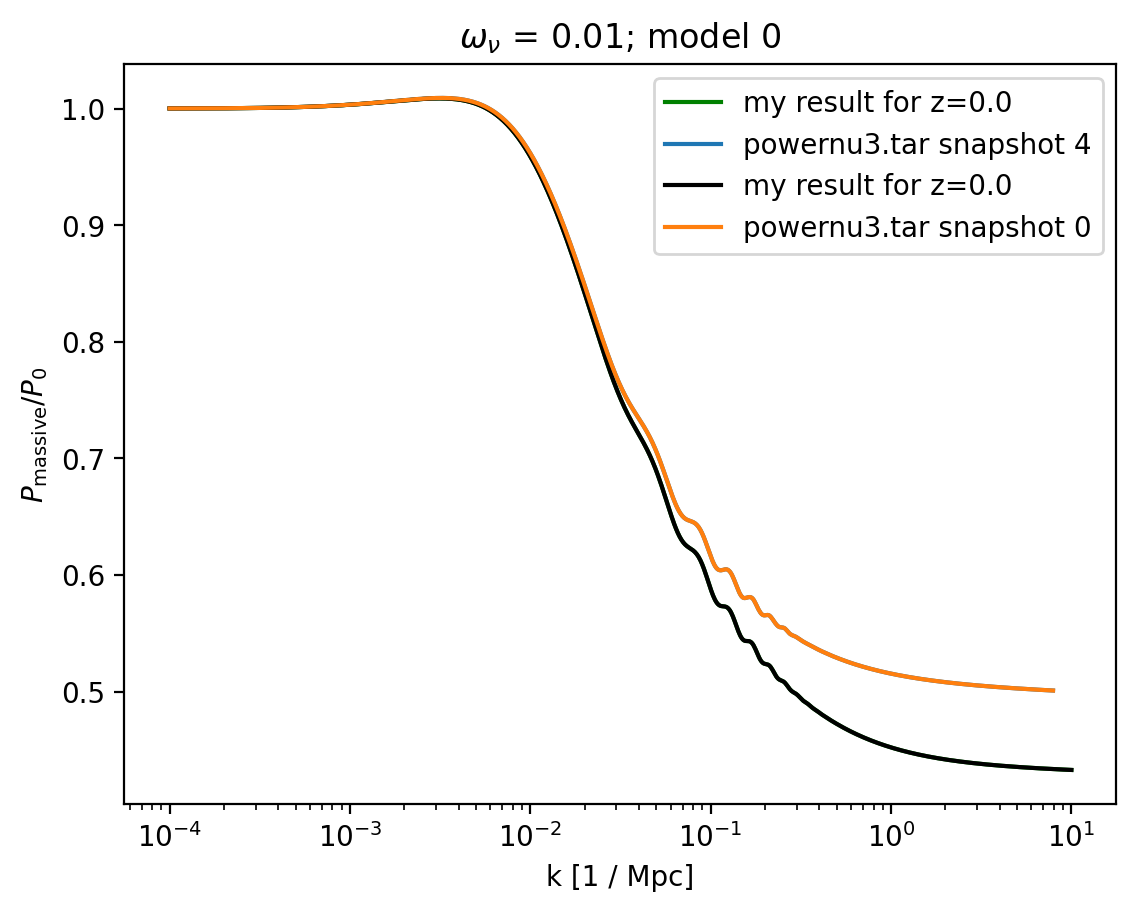

In [11]:
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(modeli)

print(z_list)
spectrum = spectra[omnuh2_float][modeli][j]

plt.plot(spectrum["k"], spectrum["P_nu"] / spectrum["P_no"], c=ci.colors[modeli],
    label="my result for z=" + str(z_list[j]))
plt.plot(true[j]["k"], true[j]["ratio"],
         label="powernu3.tar snapshot 4")
spectrum = spectra[omnuh2_float][modeli][j]

plt.plot(spectrum["k"], spectrum["P_nu"] / spectrum["P_no"], c="black",
    label="my result for z=" + str(z_list[j]))
plt.plot(true[j]["k"], true[j]["ratio"],
         label="powernu3.tar snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; model " + str(modeli))
plt.legend()

# This protects other cells by avoiding unintended reuse
del j, z_list, spectrum

[2.   1.   0.57 0.3  0.  ]
# k values in my spectrum 1000
# k values in Ariel's spectrum 1000
0       True
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: k, Length: 1000, dtype: bool


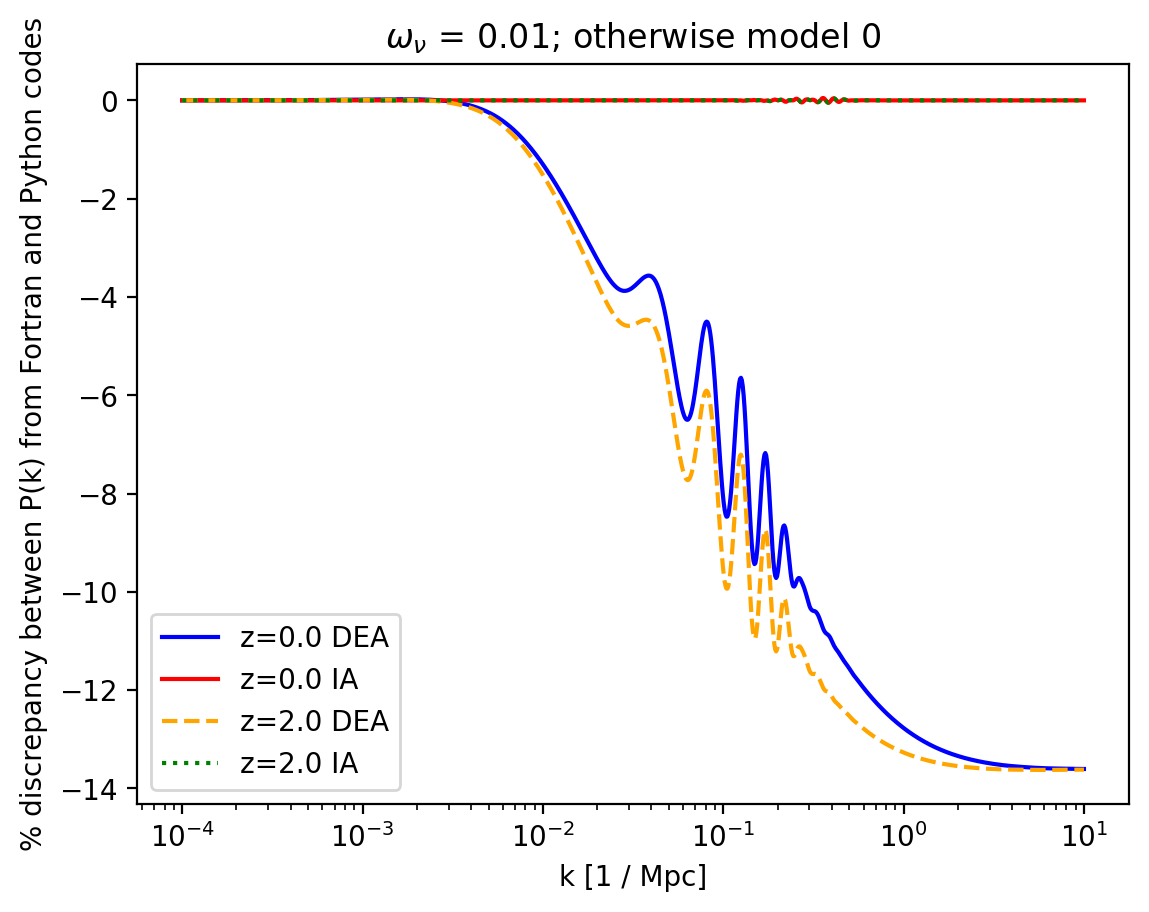

In [23]:
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(modeli)

print(z_list)

spectrum = spectra[omnuh2_float][modeli][j]

x_direct = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true[j]["ratio"]

my_Pk = p_interpolator.P(z_list[j], true[j]["k"])
my_MEMNeC_Pk = p_MEMNeC_interpolator.P(z_list[j], true[j]["k"])
x_interpolator = my_Pk / my_MEMNeC_Pk

plt.plot(spectrum["k"], percent_error(x_Ariel, x_direct), c="blue",
    label="z=" + str(z_list[j]) + " DEA",)
plt.plot(spectrum["k"], percent_error(x_Ariel, x_interpolator), c="red",
    label="z=" + str(z_list[j]) + " IA")

j = 0
spectrum = spectra[omnuh2_float][modeli][j]
x_direct = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true[j]["ratio"]

my_Pk = p_interpolator.P(z_list[j], true[j]["k"])
my_MEMNeC_Pk = p_MEMNeC_interpolator.P(z_list[j], true[j]["k"])
x_interpolator = my_Pk / my_MEMNeC_Pk

plt.plot(spectrum["k"], percent_error(x_Ariel, x_direct), c="orange",
    label="z=" + str(z_list[j]) + " DEA", linestyle="dashed")
plt.plot(spectrum["k"], percent_error(x_Ariel, x_interpolator), c="green",
    label="z=" + str(z_list[j]) + " IA", linestyle="dotted")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between P(k) from Fortran and Python codes")
# Plot 蠼
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; otherwise model " + str(modeli))
plt.legend()

# plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del j, z_list, spectrum

In [28]:
# Point of this cell:
# What if we skip the Boltzmann battery generator and directly call the
# evaluate_cosmology function?

j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(modeli)

print(z_list)    

k, z, p, s = ci.evaluate_cosmology(model,
    redshifts=np.array([z_list[j]]), fancy_neutrinos=False,
    k_points=1000, hubble_units=False)
k, z, p_MEMNeC, s = ci.evaluate_cosmology(MEMNeC,
    redshifts=np.array([z_list[j]]), fancy_neutrinos=False,
    k_points=1000, hubble_units=False)

#spectrum = spectra[omnuh2_float][modeli][j]
x_direct = p / p_MEMNeC
x_Ariel = true[j]["ratio"]

common_k, trunc_Ariel_x, aligned_Lukas_x = \
    ci.truncator(true[j]["k"], x_Ariel,
             k, x_direct)

plt.plot(common_k,
         percent_error(trunc_Ariel_x, aligned_Lukas_x),
         c="blue", label="z=" + str(z_list[j]) + " DEA")

j = 0
k, z, p, s = ci.evaluate_cosmology(model,
    redshifts=np.array([z_list[j]]), fancy_neutrinos=False,
    k_points=1000, hubble_units=False)
k, z, p_MEMNeC, s = ci.evaluate_cosmology(MEMNeC,
    redshifts=np.array([z_list[j]]), fancy_neutrinos=False,
    k_points=1000, hubble_units=False)
#spectrum = spectra[omnuh2_float][modeli][j]
x_direct = p / p_MEMNeC
x_Ariel = true[j]["ratio"]

common_k, trunc_Ariel_x, aligned_Lukas_x = \
    ci.truncator(true[j]["k"], x_Ariel,
             k, x_direct)

plt.plot(common_k,
         percent_error(trunc_Ariel_x, aligned_Lukas_x),
         c="orange", label="z=" + str(z_list[j]) + " DEA",
         linestyle="dashed")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between P(k) from Fortran and Python codes")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; otherwise model " + str(modeli))
plt.legend()

# plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del j, z_list

[2.   1.   0.57 0.3  0.  ]


NameError: name 'truncator' is not defined

[2.   1.   0.57 0.3  0.  ]


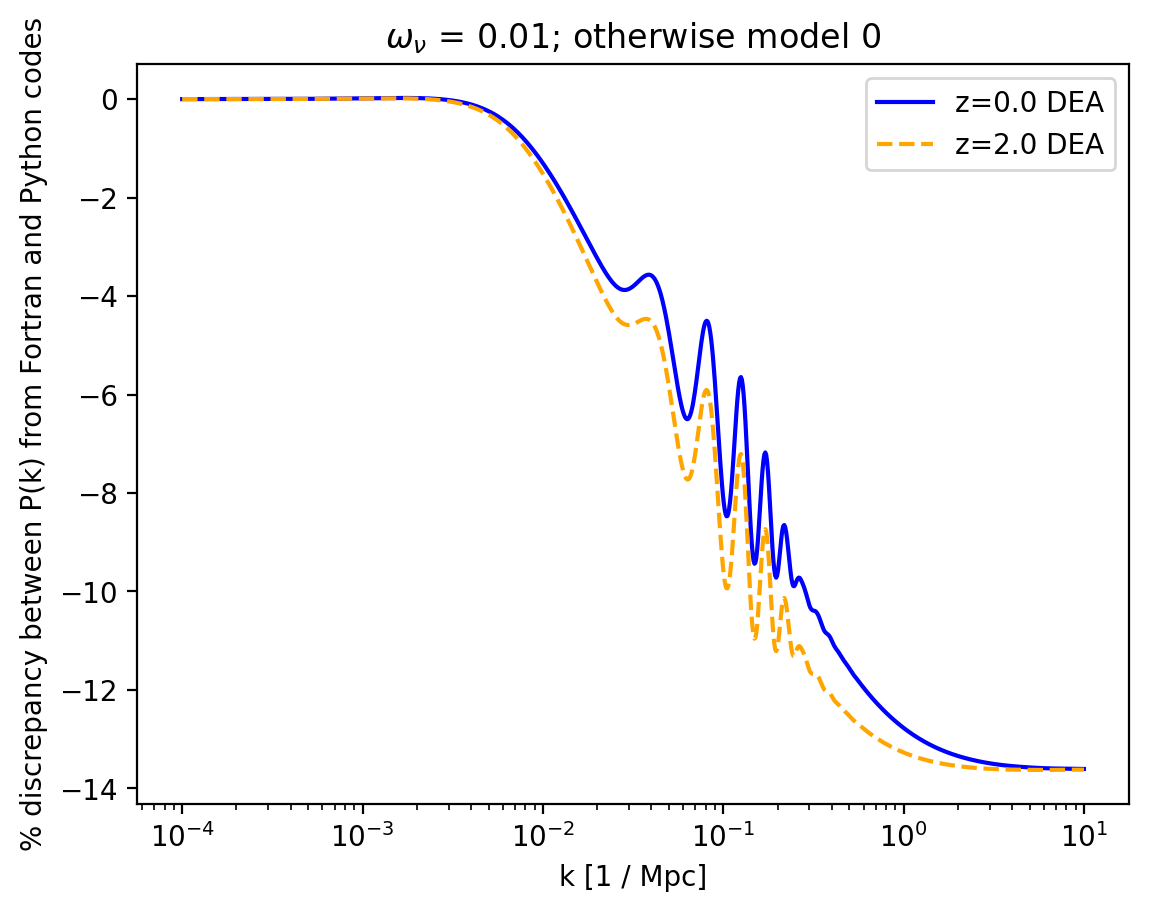

In [27]:
# Point of this cell:
# What happens if we interpolate so that the k axes are the same?

j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(modeli)

print(z_list)

spectrum = spectra[omnuh2_float][modeli][j]

x_direct = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true[j]["ratio"]

plt.plot(spectrum["k"], percent_error(x_Ariel, x_direct), c="blue",
    label="z=" + str(z_list[j]) + " DEA",)

j = 0
spectrum = spectra[omnuh2_float][modeli][j]
x_direct = spectrum["P_nu"] / spectrum["P_no"]
x_Ariel = true[j]["ratio"]

plt.plot(spectrum["k"], percent_error(x_Ariel, x_direct), c="orange",
    label="z=" + str(z_list[j]) + " DEA", linestyle="dashed")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between P(k) from Fortran and Python codes")
plt.title(r"$\omega_\nu$ = " + omnuh2_str + "; otherwise model " + str(modeli))
plt.legend()

# plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del j, z_list, spectrum

[2.   1.   0.57 0.3  0.  ]


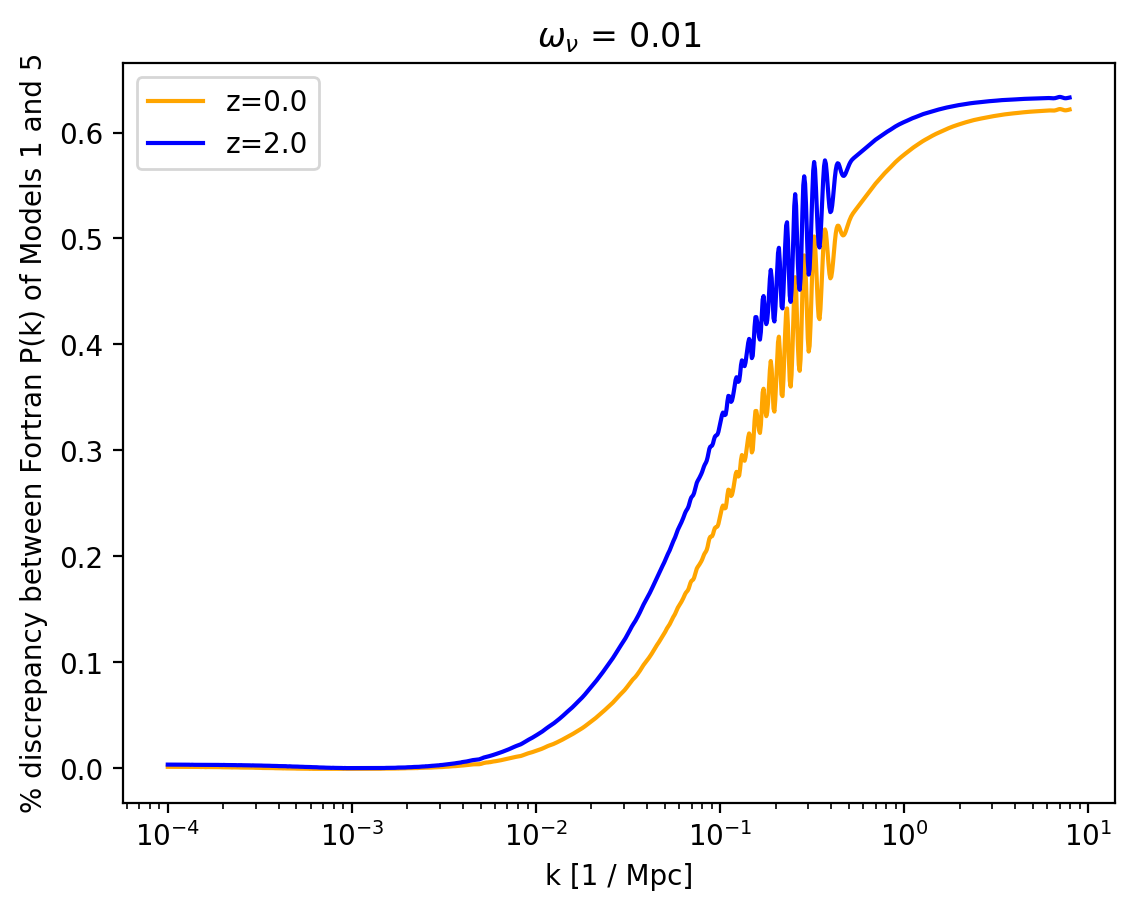

In [13]:
j = 4 # this should be SNAP index, not z index
z_list = ci.parse_redshifts(modeli)

print(z_list)

plt.plot(true[j]["k"], percent_error(powernu3[omnuh2_str][1][j]["ratio"],
    powernu3[omnuh2_str][5][j]["ratio"]), c="orange",
    label="z=" + str(z_list[j]))

j = 0

plt.plot(true[j]["k"], percent_error(powernu3[omnuh2_str][1][j]["ratio"],
    powernu3[omnuh2_str][5][j]["ratio"]), c="blue",
    label="z=" + str(z_list[j]))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"% discrepancy between Fortran P(k) of Models 1 and 5")
plt.title(r"$\omega_\nu$ = " + omnuh2_str)
plt.legend()

#plt.savefig("../plots/camb_interface/accuracy/model0.png")
# This protects other cells by avoiding unintended reuse
del j, z_list